Code to replicate sequence-to-sequence architecture, with Luong global attention

In [ ]:
# https://arxiv.org/pdf/1508.04025.pdf
# https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html#a-family-of-attention-mechanisms
# https://blog.floydhub.com/attention-mechanism/
# https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data
from torchtext import datasets
import re
import spacy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
!python -m spacy download de_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [ ]:
# https://stackoverflow.com/questions/56927602/unable-to-load-the-spacy-model-en-core-web-lg-on-google-colab
# https://spacy.io/usage/models

!pip install de_core_news_sm

In [ ]:
import de_core_news_sm
spacy_de = de_core_news_sm.load()

In [ ]:
!pip install en_core_web_sm

In [ ]:
import en_core_web_sm
spacy_en = en_core_web_sm.load()

In [ ]:
url = re.compile('(<url>.*</url>)')

In [ ]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(url.sub('@URL@', text))]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(url.sub('@URL@', text))]

In [ ]:
from torchtext.data.utils import get_tokenizer

DE = data.Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>')
EN = data.Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/data/data/translation/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data, valid_data, test_data = datasets.Multi30k.splits(exts=('.de', '.en'), fields=(DE, EN))
print('Loaded data...')

Loaded data...


In [ ]:
print(train_data.fields)
print(len(train_data))
print(len(valid_data))
print(vars(train_data[0]))
print(vars(train_data[100]))
print(vars(valid_data[100]))

{'src': <torchtext.data.field.Field object at 0x7f5e16220ba8>, 'trg': <torchtext.data.field.Field object at 0x7f5e16220c18>}
29000
1014
{'src': ['Zwei', 'junge', 'weiße', 'Männer', 'sind', 'im', 'Freien', 'in', 'der', 'Nähe', 'vieler', 'Büsche', '.'], 'trg': ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['Männliches', 'Kleinkind', 'in', 'einem', 'roten', 'Hut', ',', 'das', 'sich', 'an', 'einem', 'Geländer', 'festhält', '.'], 'trg': ['Toddler', 'boy', 'in', 'a', 'red', 'hat', 'holding', 'on', 'to', 'some', 'railings', '.']}
{'src': ['Ein', 'älterer', ',', 'übergewichtiger', 'Mann', 'wendet', 'einen', 'Pfannkuchen', ',', 'während', 'er', 'Frühstück', 'macht', '.'], 'trg': ['An', 'older', ',', 'overweight', 'man', 'flips', 'a', 'pancake', 'while', 'making', 'breakfast', '.']}


In [ ]:
# set source and target language
DE.build_vocab(train_data.src, min_freq=3)
EN.build_vocab(train_data.trg, min_freq=3)

In [ ]:
train_iter, valid_iter = data.BucketIterator.splits((train_data, valid_data), batch_size=32, device=device)

print(DE.vocab.freqs.most_common(10))
print(len(DE.vocab))
print(EN.vocab.freqs.most_common(10))
print(len(EN.vocab))

[('.', 28821), ('Ein', 13904), ('einem', 13697), ('in', 11830), (',', 8938), ('und', 8925), ('mit', 8838), ('auf', 8686), ('Mann', 7805), ('einer', 6750)]
5500
[('a', 31707), ('.', 27623), ('A', 17458), ('in', 14847), ('the', 9923), ('on', 8019), ('is', 7524), ('and', 7378), ('man', 7359), ('of', 6871)]
4727


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, device):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size

        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size)

        self.device = device
        self.to(self.device)
        
    def forward(self, input, hidden):
        # input is of shape [1, batch_size]
        # embedded is of shape [1, batch_size, embedding_size]

        input = input.to(self.device)

        embedded = self.embed(input)

        output, hidden = self.gru(embedded, hidden)

        # output shape is [1, batch_size, hidden_dim]
        # hidden shape is [num_layers, batch_size, hidden_dim]

        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)


In [77]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, n_dropout, attend_type, device):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_dropout = n_dropout
        self.attend_type = attend_type

        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(self.embedding_size, self.hidden_size)
        self.dropout = nn.Dropout(self.n_dropout)

        self.align = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.align_gen = nn.Linear(self.hidden_size, self.hidden_size)
        self.V = nn.Parameter(torch.rand(hidden_size))

        self.appl_context = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self.device = device
        self.to(self.device)

    def attend_concat(self, enc_outputs, dec_output):
        # dec_output:  [1, batch_size, hidden_dim]
        # enc_outputs is of shape [sequence_len, batch_size, hidden_dim]

        batch_size = dec_output.size(1)
        sequence_len = enc_outputs.size(0)

        dec_output = dec_output.repeat(sequence_len, 1, 1)
        #dec_output:  [sequence_len, batch_size, hidden_dim]

        attn_in = torch.cat((enc_outputs, dec_output), dim=-1)
        # combined enc_outputs and hidden:  [sequence_len, batch_size, hidden_dim * 2]

        aligned = self.align(attn_in)
        aligned = torch.tanh(aligned)
    
        aligned = aligned.permute(1, 2, 0)
        #aligned = [batch size, hidden_dim, sequence_len]
        
        #v = [hidden_dim]
        v = self.V.repeat(batch_size, 1).unsqueeze(1)
        #v = [batch size, 1, hidden_dim]

        attention = torch.bmm(v, aligned).squeeze(1)
        #attention = [batch size, sequence_len]

        return attention

    def attend_dot(self, enc_outputs, dec_output):
        # dec_output:  [1, batch_size, hidden_dim]
        # enc_outputs is of shape [sequence_len, batch_size, hidden_dim]
        
        dec_output = dec_output.permute(1, 0, 2)
        # dec_output:  [batch_size, 1, hidden_dim]

        enc_outputs = enc_outputs.permute(1, 2, 0)
        # enc_outputs is of shape [batch_size, hidden_dim, sequence_len]
        
        attention = torch.bmm(dec_output, enc_outputs)
        # weighted = [batch_size, 1, sequence_len]

        attention = attention.squeeze(1)
        # attention is of shape [batch_size, sequence_len]

        return attention

    def attend_general(self, enc_outputs, dec_output):
        # dec_output:  [1, batch_size, hidden_dim]
        # enc_outputs is of shape [sequence_len, batch_size, hidden_dim]

        enc_outputs = self.align_gen(enc_outputs)
        # enc_outputs is of shape [sequence_len, batch_size, hidden_dim]

        dec_output = dec_output.permute(1, 0, 2)
        enc_outputs = enc_outputs.permute(1, 2, 0)
        attention = torch.bmm(dec_output, enc_outputs)
        attention = attention.squeeze(1)

        return attention

    def forward(self, input, hidden, enc_outputs):
        # input is of shape [batch_size]
        # enc_outputs is of shape [sequence_len, batch_size, hidden_dim]
        # hidden is of shape [1, batch_size, hidden_dim]

        # Decoder

        batch_size = hidden.size(1)
        
        input = input.unsqueeze(0)
        # now, input shape is [1, batch_size]

        input = input.to(self.device)

        embedded = self.embed(input)
        embedded = self.dropout(embedded)
        # embedded is of shape [1, batch_size, embedding_dim]

        output, hidden = self.gru(embedded, hidden)
        #output:  [1, batch_size, hidden_dim]

        # Attention

        if self.attend_type == 'concat':
            attention = self.attend_concat(enc_outputs, output)
        elif self.attend_type == 'dot':
            attention = self.attend_dot(enc_outputs, output)
        elif self.attend_type == 'general':
            attention = self.attend_general(enc_outputs, output)

        alphas = F.softmax(attention, dim=1)
        #alphas = [batch_size, sequence_len]

        alphas = alphas.unsqueeze(1)
        #alphas =  [batch_size, 1, sequence_len]

        # enc_outputs is of shape [sequence_len, batch_size, hidden_dim]
        enc_outputs = enc_outputs.permute(1, 0, 2)
        #enc_outputs = [batch_size, sequence_len, hidden_dim]

        context = torch.bmm(alphas, enc_outputs)
        #weighted = [batch_size, 1, hidden_dim]
        
        context = context.permute(1, 0, 2)
        #context: [1, batch_size, hidden_dim]

        output = torch.cat((output, context), dim=-1)
        #output:  [1, batch_size, hidden_dim * 2]

        output = self.appl_context(output)
        output = torch.tanh(output)

        output = self.out(output.squeeze(0))
        #output:  [1, batch_size, vocab_size]

        output = self.logsoftmax(output)

        return output, hidden, alphas


In [ ]:
#print(enc)
#print(dec)

In [78]:
vocab_size_src = len(DE.vocab)
vocab_size_trg = len(EN.vocab)

embedding_size = 300
hidden_size = 128
n_dropout = 0.1
attend_type = 'general'

enc = EncoderRNN(vocab_size_src, embedding_size, hidden_size, device)
dec = AttentionDecoderRNN(vocab_size_trg, embedding_size, hidden_size, n_dropout, attend_type, device)

enc_optim = optim.Adam(enc.parameters())
dec_optim = optim.Adam(dec.parameters())
    
pad_idx = EN.vocab.stoi['<pad>']
print('Pad index: ', pad_idx)
criterion = nn.NLLLoss(ignore_index=pad_idx)

epochs = 20
clip = 10

epoch_losses = []

for epoch in range(epochs):
    epoch_loss = 0

    for batch in train_iter:
        hidden = enc.init_hidden(batch.src.size(1))

        max_len_enc = batch.src.size(0)

        enc_outputs, hidden = enc(batch.src, hidden)

        # enc_outputs is of shape [sequence_len, batch_size, hidden_dim]

        # store outputs
        max_len_dec = batch.trg.size(0)

        outputs = torch.zeros(max_len_dec, batch.trg.size(1), vocab_size_trg, device=device)
        input = batch.trg[0]
        
        for i in range(1, max_len_dec):
            output, hidden, alphas = dec(input, hidden, enc_outputs)
            outputs[i] = output
            input = batch.trg[i]

        enc_optim.zero_grad()
        dec_optim.zero_grad()

        target = torch.tensor(batch.trg[1:], device=device)
        loss = criterion(outputs[1:].view(-1, outputs.shape[2]), target.view(-1))
        loss.backward()

        nn.utils.clip_grad_norm_(enc.parameters(), clip)
        nn.utils.clip_grad_norm_(dec.parameters(), clip)

        enc_optim.step()
        dec_optim.step()

        epoch_loss += loss.item()
        print('\rEpoch {} : Loss {:.3f}'.format(epoch, epoch_loss / len(batch)), end="")

    print('\rEpoch {} : Loss {:.3f}'.format(epoch, epoch_loss / len(train_iter)))

    epoch_losses.append(epoch_loss / len(train_iter))

Pad index:  1
Epoch 0 : Loss 0.527

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 : Loss 4.000
Epoch 1 : Loss 3.087
Epoch 2 : Loss 2.617
Epoch 3 : Loss 2.273
Epoch 4 : Loss 2.039
Epoch 5 : Loss 1.864
Epoch 6 : Loss 1.723
Epoch 7 : Loss 1.613
Epoch 8 : Loss 1.521
Epoch 9 : Loss 1.445
Epoch 10 : Loss 1.377
Epoch 11 : Loss 1.321
Epoch 12 : Loss 1.265
Epoch 13 : Loss 1.220
Epoch 14 : Loss 1.174
Epoch 15 : Loss 1.137
Epoch 16 : Loss 1.099
Epoch 17 : Loss 1.066
Epoch 18 : Loss 1.038
Epoch 19 : Loss 1.010


Text(0.5, 1.0, 'Training loss')

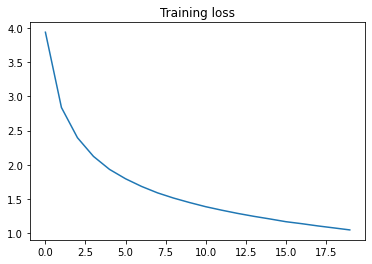

In [70]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.title("Training loss")

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(np.array(attentions))
    fig.colorbar(cax)

    # # Set up axes
    ax.set_xticklabels([''] + input_sentence +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


In [ ]:
#### Using concat

sos_idx = EN.vocab.stoi['<sos>']
eos_idx = EN.vocab.stoi['<eos>']

batch = next(iter(valid_iter))

for i in range(5):
    with torch.no_grad():
        encoder_input = batch.src[:, i].unsqueeze(1)
        hidden = enc.init_hidden(1)

        encoded = []
        for ip in encoder_input:
            encoded.append(DE.vocab.itos[ip.item()])

        enc_outputs, hidden = enc(encoder_input, hidden)

        max_len_enc = batch.src.size(0)
        max_len_dec = batch.trg.size(0)
        decoder_input = torch.tensor([sos_idx], device=device)
        decoder_attentions = torch.zeros(max_len_dec*2, max_len_enc)

        decoded = []
        decoded.append(EN.vocab.itos[sos_idx])

        true = [EN.vocab.itos[w] for w in batch.trg[:, i].unsqueeze(1)]

        k = 0
        while True:
            output, hidden, alphas = dec(decoder_input, hidden, enc_outputs)
            topv, topi = output.topk(1)
            topi = topi.squeeze(1)
            decoder_input = topi.detach()

            decoder_attentions[k] = alphas
            k += 1
            
            decoded.append(EN.vocab.itos[decoder_input.item()])
            if decoder_input.item() == eos_idx:
                break

        print(encoded)
        print(decoded)
        print(true)
        print()

        #show_attention(encoded, decoded, decoder_attentions)

['<sos>', 'Ein', 'Kind', 'sitzt', 'auf', 'einer', '<unk>', '.', '<eos>']
['<sos>', 'A', 'child', 'sits', 'on', 'a', 'wooden', 'workbench', '.', '<eos>']
['<sos>', 'A', 'child', 'sitting', 'on', 'a', 'rock', 'formation', '.', '<eos>', '<pad>', '<pad>', '<pad>']

['<sos>', 'Zwei', 'Frauen', 'lächeln', 'bei', 'einer', 'Veranstaltung', '.', '<eos>']
['<sos>', 'Two', 'women', 'are', 'smiling', 'at', 'an', 'event', '.', '<eos>']
['<sos>', 'Two', 'women', 'are', 'smiling', 'at', 'an', 'event', '.', '<eos>', '<pad>', '<pad>', '<pad>']

['<sos>', 'Zwei', 'Pudel', 'rennen', 'durch', 'den', 'Schnee', '.', '<eos>']
['<sos>', 'Two', 'poodles', 'running', 'through', 'the', 'snow', '.', '<eos>']
['<sos>', 'Two', 'poodles', 'are', 'running', 'through', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>']

['<sos>', '<unk>', '<unk>', 'tagsüber', 'ihre', '<unk>', '.', '<eos>', '<pad>']
['<sos>', '<unk>', '<unk>', 'their', '<unk>', '<unk>', 'their', 'way', 'show', '.', '<eos>']
['<sos>', '<unk>', 'are

In [76]:
#### Using dot

sos_idx = EN.vocab.stoi['<sos>']
eos_idx = EN.vocab.stoi['<eos>']

batch = next(iter(valid_iter))

for i in range(5):
    with torch.no_grad():
        encoder_input = batch.src[:, i].unsqueeze(1)
        hidden = enc.init_hidden(1)

        encoded = []
        for ip in encoder_input:
            encoded.append(DE.vocab.itos[ip.item()])

        enc_outputs, hidden = enc(encoder_input, hidden)

        max_len_enc = batch.src.size(0)
        max_len_dec = batch.trg.size(0)
        decoder_input = torch.tensor([sos_idx], device=device)
        decoder_attentions = torch.zeros(max_len_dec*2, max_len_enc)

        decoded = []
        decoded.append(EN.vocab.itos[sos_idx])

        true = [EN.vocab.itos[w] for w in batch.trg[:, i].unsqueeze(1)]

        k = 0
        while True:
            output, hidden, alphas = dec(decoder_input, hidden, enc_outputs)
            topv, topi = output.topk(1)
            topi = topi.squeeze(1)
            decoder_input = topi.detach()

            decoder_attentions[k] = alphas
            k += 1
            
            decoded.append(EN.vocab.itos[decoder_input.item()])
            if decoder_input.item() == eos_idx:
                break

        print(encoded)
        print(decoded)
        print(true)
        print()

        #show_attention(encoded, decoded, decoder_attentions)

['<sos>', 'Ein', 'Kind', 'sitzt', 'auf', 'einer', '<unk>', '.', '<eos>']
['<sos>', 'A', 'child', 'sits', 'on', 'a', '<unk>', 'wall', '.', '<eos>']
['<sos>', 'A', 'child', 'sitting', 'on', 'a', 'rock', 'formation', '.', '<eos>', '<pad>', '<pad>', '<pad>']

['<sos>', 'Zwei', 'Frauen', 'lächeln', 'bei', 'einer', 'Veranstaltung', '.', '<eos>']
['<sos>', 'Two', 'women', 'are', 'smiling', 'at', 'an', 'event', '.', '<eos>']
['<sos>', 'Two', 'women', 'are', 'smiling', 'at', 'an', 'event', '.', '<eos>', '<pad>', '<pad>', '<pad>']

['<sos>', 'Zwei', 'Pudel', 'rennen', 'durch', 'den', 'Schnee', '.', '<eos>']
['<sos>', 'Two', 'poodles', 'are', 'running', 'through', 'the', 'snow', '.', '<eos>']
['<sos>', 'Two', 'poodles', 'are', 'running', 'through', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>']

['<sos>', '<unk>', '<unk>', 'tagsüber', 'ihre', '<unk>', '.', '<eos>', '<pad>']
['<sos>', '<unk>', '<unk>', '<unk>', 'their', '<unk>', 'for', 'a', '<unk>', '.', '<eos>']
['<sos>', '<unk>', 'are',

In [79]:
#### Using general

sos_idx = EN.vocab.stoi['<sos>']
eos_idx = EN.vocab.stoi['<eos>']

batch = next(iter(valid_iter))

for i in range(5):
    with torch.no_grad():
        encoder_input = batch.src[:, i].unsqueeze(1)
        hidden = enc.init_hidden(1)

        encoded = []
        for ip in encoder_input:
            encoded.append(DE.vocab.itos[ip.item()])

        enc_outputs, hidden = enc(encoder_input, hidden)

        max_len_enc = batch.src.size(0)
        max_len_dec = batch.trg.size(0)
        decoder_input = torch.tensor([sos_idx], device=device)
        decoder_attentions = torch.zeros(max_len_dec*2, max_len_enc)

        decoded = []
        decoded.append(EN.vocab.itos[sos_idx])

        true = [EN.vocab.itos[w] for w in batch.trg[:, i].unsqueeze(1)]

        k = 0
        while True:
            output, hidden, alphas = dec(decoder_input, hidden, enc_outputs)
            topv, topi = output.topk(1)
            topi = topi.squeeze(1)
            decoder_input = topi.detach()

            decoder_attentions[k] = alphas
            k += 1
            
            decoded.append(EN.vocab.itos[decoder_input.item()])
            if decoder_input.item() == eos_idx:
                break

        print(encoded)
        print(decoded)
        print(true)
        print()

        #show_attention(encoded, decoded, decoder_attentions)

['<sos>', 'Ein', 'Kind', 'sitzt', 'auf', 'einer', '<unk>', '.', '<eos>']
['<sos>', 'A', 'child', 'is', 'sitting', 'on', 'a', '<unk>', '.', '<eos>']
['<sos>', 'A', 'child', 'sitting', 'on', 'a', 'rock', 'formation', '.', '<eos>', '<pad>', '<pad>', '<pad>']

['<sos>', 'Zwei', 'Frauen', 'lächeln', 'bei', 'einer', 'Veranstaltung', '.', '<eos>']
['<sos>', 'Two', 'women', 'smiling', 'at', 'an', 'event', '.', '<eos>']
['<sos>', 'Two', 'women', 'are', 'smiling', 'at', 'an', 'event', '.', '<eos>', '<pad>', '<pad>', '<pad>']

['<sos>', 'Zwei', 'Pudel', 'rennen', 'durch', 'den', 'Schnee', '.', '<eos>']
['<sos>', 'Two', 'poodles', 'are', 'running', 'through', 'the', 'snow', '.', '<eos>']
['<sos>', 'Two', 'poodles', 'are', 'running', 'through', 'the', 'snow', '.', '<eos>', '<pad>', '<pad>', '<pad>']

['<sos>', '<unk>', '<unk>', 'tagsüber', 'ihre', '<unk>', '.', '<eos>', '<pad>']
['<sos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '.', '<eos>']
['<sos>', '<unk>', 'are', 'perform